In [1]:
import os
import json
import glob
import numpy as np
import cv2
import rasterio as rio #!pip install rasterio
import tacoreader #!pip install tacoreader
import gzip 

def show_jpg(im0, quality=95, width_perc=100, src_is_rgb=False):
    import base64, cv2
    import IPython.display
    if src_is_rgb and len(im0.shape)>2:
        im0 = im0[:,:,::-1]
    _, encoded_img = cv2.imencode('.jpg', im0, [int(cv2.IMWRITE_JPEG_QUALITY), quality, int(cv2.IMWRITE_JPEG_SAMPLING_FACTOR), int(cv2.IMWRITE_JPEG_SAMPLING_FACTOR_444)])
    img_base64 = base64.b64encode(encoded_img).decode()
    style_txt = "width:{im0.shape[1]}px; height:{im0.shape[0]}px;" if width_perc <= 0 else f"width:{width_perc}%; height:auto;"
    IPython.display.display(IPython.display.HTML(f'<img src="data:image/jpeg;base64,{img_base64}" style="{style_txt}">'))

def prep4cv(im0, norm_fac=255.0/4095.0):
    return np.ascontiguousarray(np.transpose(np.uint8(np.clip(np.round(im0*norm_fac),0,255)),(1,2,0)))

def get_samples(idx0):
    lr_point = datapoints.read(idx0).read(0)
    hr_point = datapoints.read(idx0).read(1)
    with rio.open(lr_point) as src, rio.open(hr_point) as dst:
        return [prep4cv(dst.read()), prep4cv(src.read())]

#['internal:subfile', 'tortilla:id', 'tortilla:file_format', 'tortilla:data_split', 'tortilla:offset', 'tortilla:length', 'stac:crs', 'stac:geotransform', 'stac:raster_shape', 'stac:time_start', 'stac:centroid']

s2naip_dir = '/workspace/eos/sen2naipv2/'
datapoints = tacoreader.load(os.path.join(s2naip_dir, 'sen2naipv2-unet.0000.part.taco'))
naip_dwnl_dir = '/workspace/naip_dwnl/'
with gzip.open(naip_dwnl_dir+'/sen2naip_meta.json.gz') as f:
    meta0 = json.load(f)

In [347]:
#json.dump(meta0, open('sen2naip_meta.json','wt'), sort_keys=True)
#!gzip sen2naip_meta.json
#!cp sen2naip_meta.json.gz /workspace/naip_dwnl/

In [2]:
len(meta0['res_s2']),len(meta0['sids']), len(meta0['res_naip']),len(meta0['nids'])

(17051, 6799, 17051, 11304)

In [18]:
from pystac_client import Client #!pip install pystac_client planetary_computer
import planetary_computer
root_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(root_url, modifier=planetary_computer.sign_inplace)
naip_coll = catalog.get_collection("naip")
s2_coll = catalog.get_collection("sentinel-2-l2a")

In [302]:
from rasterio.shutil import copy as rio_copy
import time

def download_geotiff(item0, dst_path, cat_coll=None, asset_order= ['image'], sleep_between_sec=0.1):
    if not cat_coll is None:#refresh old url with object from catalog.get_collection("naip")
        print("Getting url")
        item0 = cat_coll.get_item(item0 if isinstance(item0, str) else item0.id)
        time.sleep(sleep_between_sec)
        print("Got ", item0)
        
    signed_item = planetary_computer.sign(item0)
    bands = []
    desc = []
    for asset0 in asset_order:
        image_url = signed_item.assets.get(asset0).href
        with rasterio.Env():
            with rasterio.open(image_url) as src:
                profile0 = src.profile.copy()
                profile0.update({
                "driver": "GTiff",
                "compress": "none"  # No compression = lossless
                })
                if len(asset_order) == 1:
                    rio_copy(src, dst_path, **profile0)
                else:
                    desc.append(src.descriptions[0] if src.descriptions[0] else asset0)
                    bands.append(src.read(1))
    if len(asset_order) > 1:
        stacked = np.stack(bands)
        profile0.update(count=len(bands))
        with rasterio.open(dst_path, 'w', **profile0) as dst:
            dst.write(stacked)
            for i, desc in enumerate(desc):
                dst.set_band_description(i+1, desc)


for idx0 in [18]:
    for k in meta0['res_s2'][idx0]['sids'].keys():
    #for k in keys0:
        trg_file = naip_dwnl_dir+'/s2fulltiffs/'+k+'.tif'
        if os.path.exists(trg_file):
            continue
        download_geotiff(k, trg_file, s2_coll, asset_order=['B04','B03','B02','B08'])

Getting url
Got  <Item id=S2A_MSIL2A_20200623T184921_R113_T10SEH_20200823T193933>
Getting url
Got  <Item id=S2B_MSIL2A_20200618T184919_R113_T10SEH_20210713T200112>
Getting url
Got  <Item id=S2A_MSIL2A_20200613T184921_R113_T10SEH_20200827T054530>


In [351]:
from rasterio.transform import array_bounds, Affine
from rasterio.warp import reproject, Resampling
resampling_method = Resampling.lanczos 
#resampling_method = Resampling.nearest 
norm_fac = 1.0
norm_fac=255.0/4095.0
idx0 = 1005
vis_result = {}
show_samples = {idx0:get_samples(idx0)}
dp = datapoints.read(idx0)
height, width = dp['stac:raster_shape'][0]
crs = rasterio.crs.CRS.from_epsg(int(dp['stac:crs'][0].split(':')[-1]))
transform =  Affine.from_gdal(*dp['stac:geotransform'][0])
#keys0 = ['S2A_MSIL2A_20200623T184921_R113_T10SEH_20200823T193933',
# 'S2B_MSIL2A_20200618T184919_R113_T10SEH_20210713T200112',
# 'S2A_MSIL2A_20200613T184921_R113_T10SEH_20200827T054530']
#for k in keys0:
for k in meta0['res'][idx0]['sids'].keys():
    load_path = naip_dwnl_dir+'/s2fulltiffs/'+k+'.tif'
    with rasterio.Env():
        with rasterio.open(load_path) as src:
            dst_array = np.zeros((src.count, height, width), dtype=np.float32)
            for i in range(4):
                reproject(  source=rasterio.band(src, i + 1),
                            destination=dst_array[i],
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=crs,  # destination is in Web Mercator
                            resampling=resampling_method    # or cubic, lanczos, etc.
                        )
            dst_array = np.ascontiguousarray(np.transpose(np.uint8(np.clip(np.round(dst_array*norm_fac),0,255)),(1,2,0)))
            vis_result[load_path] = dst_array

Results for resampling_method: Resampling.lanczos
/workspace/naip_dwnl//s2fulltiffs/S2A_MSIL2A_20180711T183921_R070_T10SGD_20201011T143353.tif



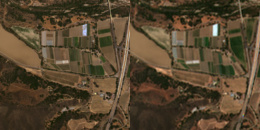

In [352]:
print("Results for resampling_method:", resampling_method)
#as_imgs = []
for k, v in vis_result.items():
    print(k)
    show_line = np.hstack([show_samples[idx0][1][:,:,:3],v[:,:,:3]])
    show_jpg(show_line,src_is_rgb=True)

In [132]:
from rasterio.shutil import copy as rio_copy
import time

def download_geotiff(item0, dst_path, naip_coll=None, sleep_between_sec=0.1):
    if not naip_coll is None:#refresh old url with object from catalog.get_collection("naip")
        item0 = naip_coll.get_item(item0.id)
        time.sleep(sleep_between_sec)
        
    signed_item = planetary_computer.sign(item0)
    image_url = signed_item.assets.get("image").href
    with rasterio.Env():
        with rasterio.open(image_url) as src:
            profile = src.profile.copy()
            profile.update({
                "driver": "GTiff",
                "compress": "none"  # No compression = lossless
            })
            rio_copy(src, dst_path, **profile)
#naip_coll = catalog.get_collection("naip")
trg_dir = '/workspace/test_sen2naip/'
os.makedirs(trg_dir, exist_ok=True)

max_exp = 400
search = catalog.search(
    collections=["naip"],
    datetime=f"{check_date_s}/{check_date_e}",  # exact time window
    bbox = bbox,
)
items = search.item_collection()
sleep_between_calls = 1.1
for i,s in enumerate(items):
    dst_path = f"{trg_dir}/{s.id}.tif"
    if os.path.exists(dst_path):
        continue
    download_geotiff(s, dst_path, naip_coll=None, sleep_between_sec=0.1)
    time.sleep(sleep_between_calls)

2025-07-18 10:02:45,910 - WARNING - CPLE_NotSupported in driver GTiff does not support creation option DTYPE
2025-07-18 10:02:45,912 - WARNING - CPLE_NotSupported in driver GTiff does not support creation option NODATA
2025-07-18 10:02:45,913 - WARNING - CPLE_NotSupported in driver GTiff does not support creation option WIDTH
2025-07-18 10:02:45,914 - WARNING - CPLE_NotSupported in driver GTiff does not support creation option HEIGHT
2025-07-18 10:02:45,916 - WARNING - CPLE_NotSupported in driver GTiff does not support creation option COUNT
2025-07-18 10:02:45,917 - WARNING - CPLE_NotSupported in driver GTiff does not support creation option CRS
2025-07-18 10:02:45,919 - WARNING - CPLE_NotSupported in driver GTiff does not support creation option TRANSFORM
2025-07-18 10:03:03,713 - WARNING - CPLE_NotSupported in driver GTiff does not support creation option DTYPE
2025-07-18 10:03:03,715 - WARNING - CPLE_NotSupported in driver GTiff does not support creation option NODATA
2025-07-18 10:

In [352]:
from rasterio.transform import array_bounds, Affine
import datetime

def utm_zone(lon):     # Simple UTM zone calculation
    return int((lon + 180) / 6) + 1
def estimate_bbox(lon, lat, width_m, height_m):
    wgs84 = rasterio.crs.CRS.from_epsg(4326)
    utm_crs = rasterio.crs.CRS.from_user_input(f"+proj=utm +zone={utm_zone(lon)} +datum=WGS84 +units=m +no_defs")
    utm_x, utm_y = rasterio.warp.transform(wgs84, utm_crs, [lon], [lat])
    xmin, xmax = utm_x[0] - width_m / 2,  utm_x[0] + width_m / 2
    ymin, ymax = utm_y[0] - height_m / 2,  utm_y[0] + height_m / 2
    lon_bounds, lat_bounds = rasterio.warp.transform(utm_crs, wgs84, [xmin, xmax], [ymin, ymax])
    return [min(lon_bounds), min(lat_bounds), max(lon_bounds), max(lat_bounds)]

idx0 = 1005
dp = datapoints.read(idx0)
timestamp = dp["stac:time_start"][1]
utc_time = datetime.datetime.utcfromtimestamp(timestamp)
height, width = dp['stac:raster_shape'][1]
bounds = array_bounds(height, width, Affine.from_gdal(*dp['stac:geotransform'][1]))
crs = rasterio.crs.CRS.from_epsg(int(dp['stac:crs'][1].split(':')[-1]))
bbox = rasterio.warp.transform_bounds(crs, 'EPSG:4326', *bounds)
id0 = dp['internal:subfile'][1].replace(s2naip_dir,'')

1005 (520, 520, 4) (130, 130, 4)



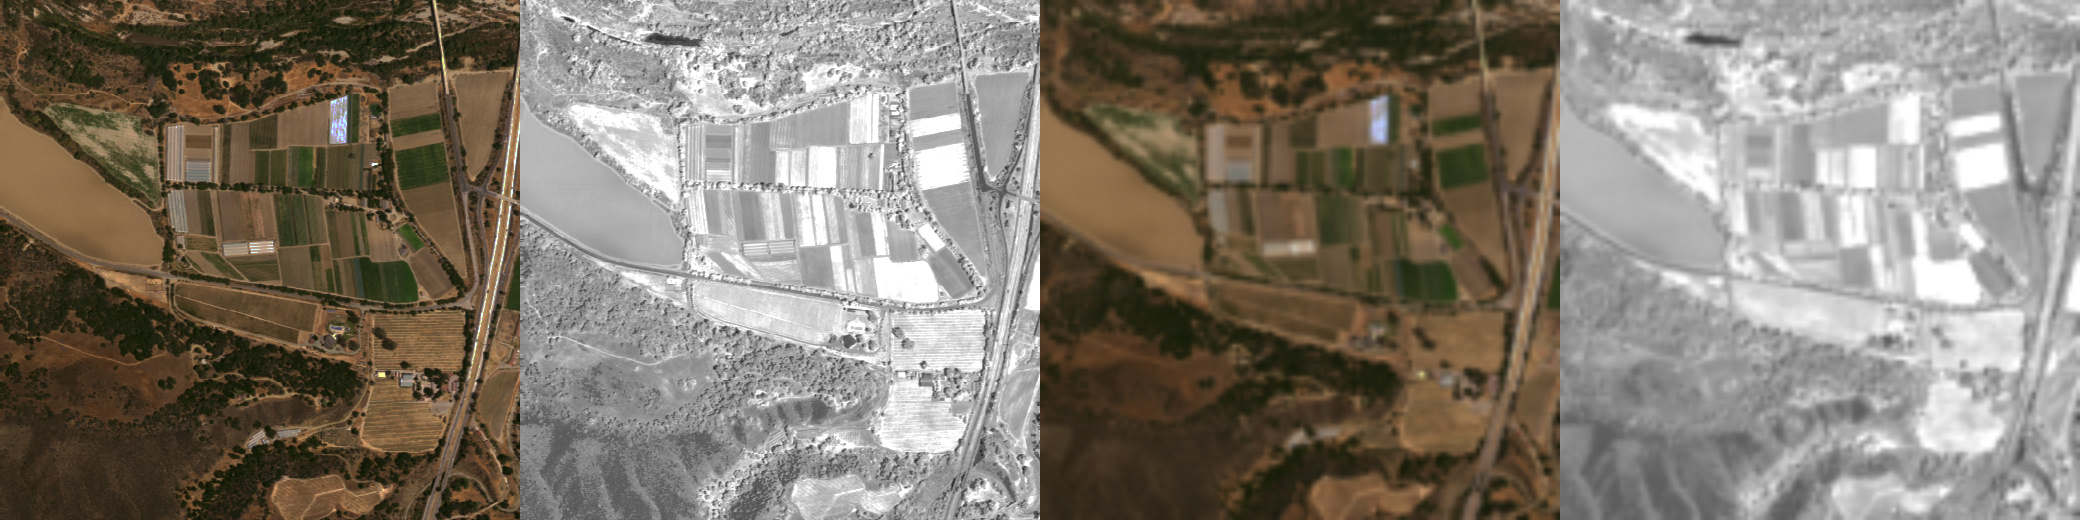

In [4]:
as_imgs = []
for k, v in show_samples.items():
    rgb_nir = [[i[:,:,:3][:,:,::-1], cv2.cvtColor(i[:,:,3], cv2.COLOR_GRAY2BGR)] for i in v]
    rgb_nir[1] = [cv2.resize(i, (rgb_nir[0][0].shape[1], rgb_nir[0][0].shape[0])) for i in rgb_nir[1]]
    show_line = np.hstack([rgb_nir[0][0],rgb_nir[0][1],rgb_nir[1][0],rgb_nir[1][1]])
    print(k, v[0].shape, v[1].shape)
    show_jpg(show_line)
    #as_imgs.append(show_line)
#cv2.imwrite('example.jpg', np.vstack(as_imgs))

In [129]:
from pyproj import Transformer
import rasterio
from rasterio.transform import rowcol
import tqdm.auto as tqdm
#item0 = naip_coll.get_item(item0['id'])
#padding allows x2 both with original roi centered or in the left/top corner
def download_roi(item0, bbox_4326, trg_filepath, pad_view=[[-0.55,-0.55],[1.05,1.05]], min_dim=320):
    signed_item = planetary_computer.sign(item0)
    signed_url = signed_item.assets.get("image").href
    if hasattr(bbox_4326, 'west'):
        bbox_4326 = [bbox_4326.west, bbox_4326.north, bbox_4326.east, bbox_4326.south]
    with rasterio.Env():
        with rasterio.open(signed_url) as src:
            src_max_hw = [src.height-1, src.width-1]
            transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)        
            coords_trg_crs = [ transformer.transform(bbox_4326[2], bbox_4326[1]), transformer.transform(bbox_4326[0], bbox_4326[3])]
            roi_corners = [rowcol(src.transform, coords_trg_crs[j][0], coords_trg_crs[j][1]) for j in range(2)] #(x0,y0), (x1,y1)
            if not pad_view is None:
                roi_hw = [roi_corners[1][j]-roi_corners[0][j] for j in range(2)]
                roi_corners = [[int(roi_hw[c]*pad_view[j][1-c])+roi_corners[j][c] for c in range(2)] for j in range(2)]
            #clip coords
            #roi_corners = [[max(min(src_max_hw[c], roi_corners[j][c]),0)  for c in range(2)] for j in range(2)]
            window = ((roi_corners[0][0], roi_corners[1][0]), (roi_corners[0][1], roi_corners[1][1])) # [(y0,y1), (x0,x1)]
            print("Info: ", window)
            return
            if min([window[i][1]-window[i][0]  for i in range(2)]) < min_dim:
                print("Info: ", window)
                return
            
            roi_data = src.read(window=window)
            meta = src.meta.copy()
            meta.update({
                "driver": "GTiff",
                "height": roi_data.shape[1],  # rows
                "width": roi_data.shape[2],   # cols
                "transform": src.window_transform(window),
                "crs": src.crs
            })
            with rasterio.open(trg_filepath, "w", **meta) as dst:
                dst.write(roi_data)

trg_dir = '/workspace/test_sen2naip/'
os.makedirs(trg_dir, exist_ok=True)

max_exp = 400
search = catalog.search(
    collections=["naip"],
    datetime=f"{check_date_s}/{check_date_e}",  # exact time window
    bbox = bbox,
)
items = search.item_collection()
                
for i,s in enumerate(items):
    trg_path = f"{trg_dir}/{idx0}_{s.id}.tif"
    if os.path.exists(trg_path):
        continue
    download_roi(s, bbox, trg_path, pad_view=[[-0.55,-0.55],[1.05,1.05]], min_dim=320)

Info:  ((6989, 1363), (10716, 4771))
Info:  ((6989, 1363), (10716, 4771))
Info:  ((6909, 1283), (10636, 4691))
Info:  ((6909, 1283), (10636, 4691))
Info:  ((4294, 921), (6527, 2961))
Info:  ((4456, 1083), (796, -2770))
Info:  ((4308, 935), (6543, 2977))
Info:  ((4468, 1095), (813, -2753))


In [159]:
import tqdm.auto as tqdm
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling
import numpy as np
import time

trg_dir = '/workspace/test_sen2naip/'
resampling_method = Resampling.lanczos 
#resampling_method = Resampling.nearest 
#vis_result, max_vis =None, -1
vis_result, max_vis = {}, 15  #keep result for visualization
timing = []

for load_path in load_paths:
    t0 = time.time()
    with rasterio.Env():
        with rasterio.open(load_path) as src:
            dst_array = np.zeros((src.count, dst.height, dst.width), dtype=np.float32)
            for i in range(4):
                reproject(  source=rasterio.band(src, i + 1),
                            destination=dst_array[i],
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=dst.transform,
                            dst_crs=dst.crs,  # destination is in Web Mercator
                            resampling=resampling_method    # or cubic, lanczos, etc.
                        )
            dst_array = np.ascontiguousarray(np.transpose(np.uint8(np.clip(np.round(dst_array),0,255)),(1,2,0)))
            vis_result[load_path] = dst_array
            t1 = time.time()
            timing.append([t1-t0])
    if len(vis_result) >= max_vis:
        break

Results for resampling_method: Resampling.nearest



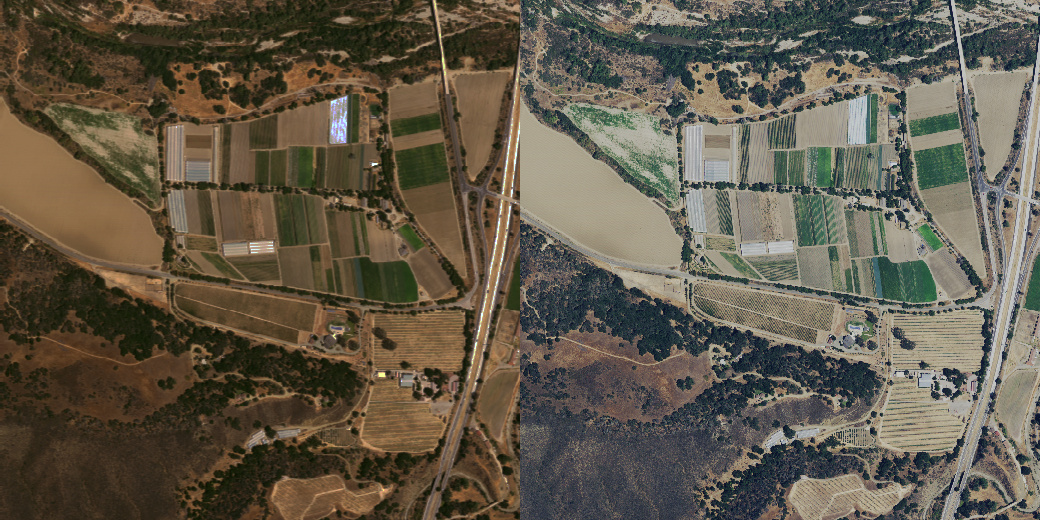

In [158]:
print("Results for resampling_method:", resampling_method)
#as_imgs = []
for k, v in vis_result.items():
    show_line = np.hstack([show_samples[idx0][0][:,:,:3][:,:,::-1] ,v[:,:,:3][:,:,::-1]])
    show_jpg(show_line)
    #as_imgs.append(show_line)
#cv2.imwrite('example.jpg', np.vstack(as_imgs))

Results for resampling_method: Resampling.lanczos



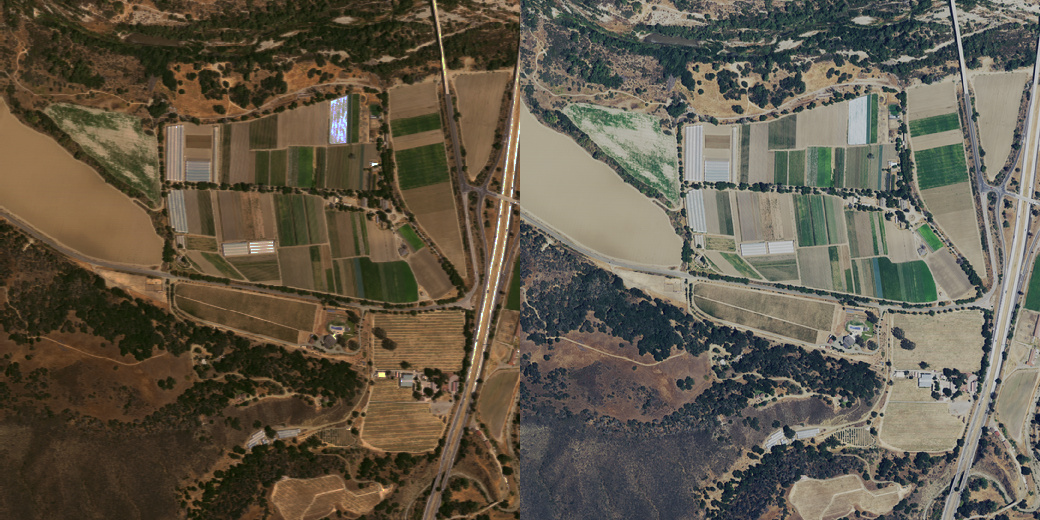

In [160]:
print("Results for resampling_method:", resampling_method)
for k, v in vis_result.items():
    show_line = np.hstack([show_samples[idx0][0][:,:,:3][:,:,::-1] ,v[:,:,:3][:,:,::-1]])
    show_jpg(show_line)

In [168]:
import opensr_degradation #!pip install opensr_degradation einops datasets

/home/udocker/.local/lib/python3.9/site-packages/opensr_degradation/naipd/main.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [169]:
degradation_model = opensr_degradation.pipe(
    sensor="naip_d",
    add_noise=True,
    params={
        "reflectance_method": [
            "identity",
            "gamma_lognormal",
            "gamma_multivariate_normal",
            "unet_histogram_matching",
            "vae_histogram_matching",
        ],
        "noise_method": "gaussian_noise",
        "device": "cuda",
        "seed": 42,
        "percentiles": [50],
        "vae_reflectance_model": opensr_degradation.naip_vae_model("cuda"),
        "unet_reflectance_model": opensr_degradation.naip_unet_model("cuda"),
    },
)

In [171]:
rgbn = vis_result['/workspace/test_sen2naip/ca_m_3412031_nw_10_060_20180724_20190208.tif']

In [251]:
import torch
from opensr_degradation.utils import hq_histogram_matching

def blur_naip(hr_hat):
    #from opensr_degradation.naipd.blur import BLUR_MODEL
    import torchvision
    BLUR_MODEL = [torchvision.transforms.GaussianBlur(13, sigma=3.0) for sigma in [3.0,2.9,2.9,3.4]]
    hr_hat_blur = []
    for i in range(hr_hat.shape[0]):
        blurred = BLUR_MODEL[i](hr_hat[i][None])
        hr_hat_blur.append(blurred[None].squeeze())
            #torch.nn.functional.interpolate(
            #    blurred[None], scale_factor=1/4, mode="bilinear", antialias=False
            #).squeeze()
        #)
    return torch.stack(hr_hat_blur)

idx_method_cmp = 3
#idx0 : original HR data
#
lr, hr = degradation_model.forward(torch.from_numpy(rgbn).float().permute(2, 0, 1)/255.0)
lr_orig = torch.from_numpy(show_samples[idx0][1]).float().permute(2, 0, 1)/255.0
hr_hat = hq_histogram_matching((hr[idx_method_cmp,...]*255.0).round()/255.0, lr_orig)
#hr_hat = hq_histogram_matching(hr[idx_method_cmp,...], lr_orig)
hr_hat_blur = blur_naip(hr_hat)

lr1 = np.ascontiguousarray(np.transpose(np.uint8(np.clip(np.round(lr.cpu().numpy()[idx_method_cmp,...]*255.0),0,255)),(1,2,0)))
hr1 = np.ascontiguousarray(np.transpose(np.uint8(np.clip(np.round(hr.cpu().numpy()[idx_method_cmp,...]*255.0),0,255)),(1,2,0)))
hr_hat1 = np.ascontiguousarray(np.transpose(np.uint8(np.clip(np.round(hr_hat.cpu().numpy()*255.0),0,255)),(1,2,0)))
hr_hat_blur1 = np.ascontiguousarray(np.transpose(np.uint8(np.clip(np.round(hr_hat_blur.cpu().numpy()*255.0),0,255)),(1,2,0)))

In [252]:
hr_hat.shape, hr_hat_blur.shape

(torch.Size([4, 520, 520]), torch.Size([4, 520, 520]))


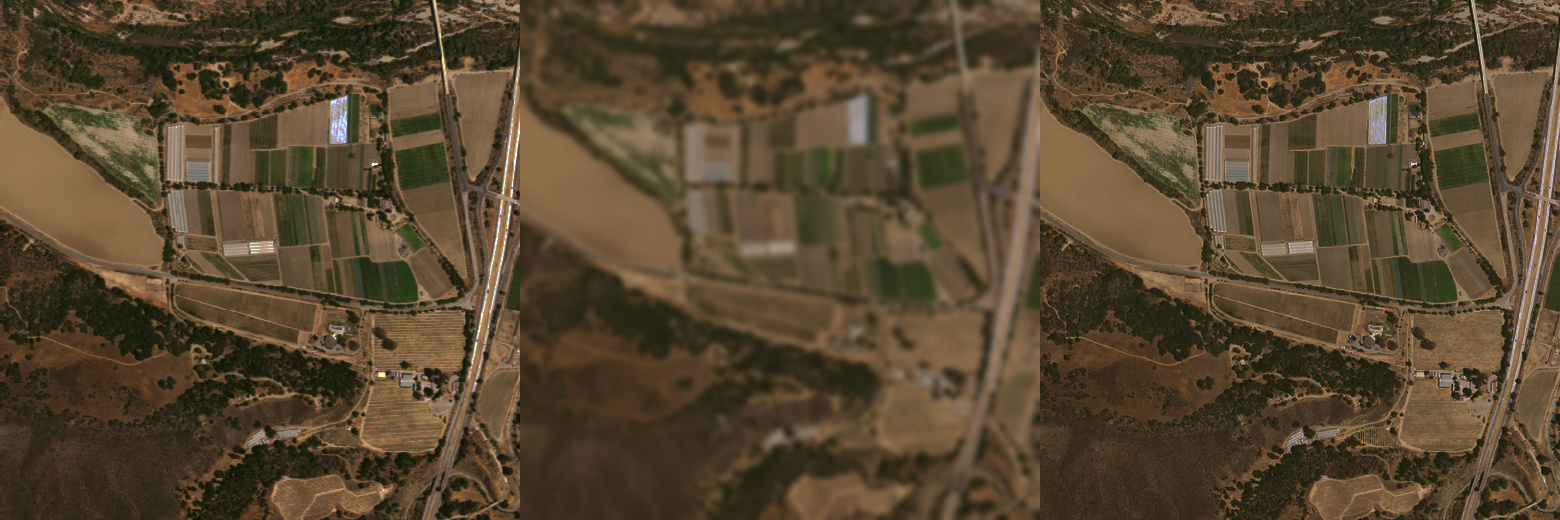

Diff:  63573431


In [253]:
#cmp_v = np.hstack([i[:,:,:3][:,:,::-1] for i in [rgbn, show_samples[idx0][0], hr_hat1, hr1, cv2.resize(lr1,(hr1.shape[1],hr1.shape[0]))]])
cmp_v = np.hstack([i[:,:,:3][:,:,::-1] for i in [show_samples[idx0][0], hr_hat_blur1, hr_hat1]])#, hr1, cv2.resize(lr1,(hr1.shape[1],hr1.shape[0]))]])
show_jpg(cmp_v)
print("Diff: ", np.sum(np.abs(show_samples[idx0][0]-hr1)))

In [ ]:
from opensr_degradation.utils import hq_histogram_matching
show_samples[idx0][1]
image_hat = hq_histogram_matching(show_samples[idx0][1], image)

In [ ]:
import opensr_degradation
import rioxarray
import datasets
import requests
import tempfile
import torch
import json


def load_metadata(metadata_path: str) -> dict:
    tmpfile = tempfile.NamedTemporaryFile(suffix=".json")
    with requests.get(metadata_path) as response:
        with open(tmpfile.name, "wb") as file:
            file.write(response.content)
        metadata_json = json.load(open(tmpfile.name, "r"))
    return metadata_json

DEMO_PATH = "https://huggingface.co/datasets/isp-uv-es/SEN2NAIP/resolve/main/demo/"

# Synthetic LR and HR data ------------------------------
synthetic_path = DEMO_PATH + "synthetic/ROI_0001/"

hr_early_data = rioxarray.open_rasterio(synthetic_path + "early/01__m_4506807_nw_19_1_20110818.tif")
hr_early_torch = torch.from_numpy(hr_early_data.to_numpy()) / 255
hr_early_metadata = load_metadata(synthetic_path + "late/metadata.json")
lr_hat, hr_hat = opensr_degradation.main.get_s2like(
    image=hr_early_torch,
    table=hr_early_metadata["sim_histograms"],
    model="gamma_multivariate_normal_50"
)

In [ ]:
def show_torch(im):
    show_jpg(np.ascontiguousarray(np.transpose(np.uint8(np.clip(np.round(im.cpu().numpy()*255.0),0,255)),(1,2,0))))

show_torch(hr_early_torch[:3,:,:])
show_torch(hr_hat[:3,:,:]*3)
show_torch(lr_hat[:3,:,:]*3)

In [184]:
#estimate bbox using centroid and metric dimensions
from rasterio.transform import array_bounds, Affine
def utm_zone(lon):     # Simple UTM zone calculation
    return int((lon + 180) / 6) + 1
def estimate_bbox(lon, lat, width_m, height_m):
    wgs84 = rasterio.crs.CRS.from_epsg(4326)
    utm_crs = rasterio.crs.CRS.from_user_input(f"+proj=utm +zone={utm_zone(lon)} +datum=WGS84 +units=m +no_defs")
    utm_x, utm_y = rasterio.warp.transform(wgs84, utm_crs, [lon], [lat])
    xmin, xmax = utm_x[0] - width_m / 2,  utm_x[0] + width_m / 2
    ymin, ymax = utm_y[0] - height_m / 2,  utm_y[0] + height_m / 2
    lon_bounds, lat_bounds = rasterio.warp.transform(utm_crs, wgs84, [xmin, xmax], [ymin, ymax])
    return [min(lon_bounds), min(lat_bounds), max(lon_bounds), max(lat_bounds)]
def calc_overlap_bounds(bounds1, bounds2):
    min_x = max(bounds1[0], bounds2[0])
    min_y = max(bounds1[1], bounds2[1])
    max_x = min(bounds1[2], bounds2[2])
    max_y = min(bounds1[3], bounds2[3])
    bounds2_area = (bounds2[2] - bounds2[0]) * (bounds2[3] - bounds2[1])
    # Check if there is an actual overlap
    if min_x > max_x or min_y > max_y or bounds2_area <= 0:
        return 0
    overlap_area = max(0, max_x - min_x)*max(0, max_y - min_y)
    return (overlap_area / bounds2_area)    

In [410]:
from tqdm.auto import tqdm
import time



#s2naip_dir = '/workspace/eos/sen2naipv2/'
#datapoints = tacoreader.load(os.path.join(s2naip_dir, 'sen2naipv2-unet.0000.part.taco'))

sleep_between_calls = 1.1
max_exp = 8
max_num = len(datapoints)
start_num = len(res_naip)
per_id = {}
chk_side = 1
for idx0 in tqdm(range(start_num,max_num)):
    dp = datapoints.read(idx0)
    #calc original timestamp
    timestamp = dp["stac:time_start"][chk_side]
    utc_time = datetime.datetime.utcfromtimestamp(timestamp) + datetime.timedelta(hours=2) #seems to have local time offset?
    start_date = utc_time - datetime.timedelta(days=1) #allow some wriggle-room due to pot. problems w. timezones
    stop_date = utc_time + datetime.timedelta(days=1)
    check_date = start_date.strftime("%Y-%m-%d")+'/'+stop_date.strftime("%Y-%m-%d")
    #calc original lon/lat bounds
    height, width = dp['stac:raster_shape'][chk_side]
    bounds = array_bounds(height, width, Affine.from_gdal(*dp['stac:geotransform'][chk_side]))
    crs = rasterio.crs.CRS.from_epsg(int(dp['stac:crs'][chk_side].split(':')[-1]))
    bbox = rasterio.warp.transform_bounds(crs, 'EPSG:4326', *bounds)
    
    search = catalog.search(
        collections= ["naip"] if chk_side == 1 else ["sentinel-2-l2a"],
        datetime=check_date,  # exact time window
        bbox = bbox,
    )
    items = search.item_collection()
    if chk_side == 1:
        naip_ids = {str(i.id):calc_overlap_bounds(i.properties['proj:bbox'],bounds) for i in items}
    else:
        naip_ids = {str(i.id):calc_overlap_bounds(i.bbox,bbox) for i in items}
    #naip_ids = {k:v for k,v in naip_ids.items() if v > 0}
    subfile = dp['internal:subfile'][chk_side].replace(s2naip_dir,'')
    for i in items:
        per_id[str(i.id)] = i.to_dict()
    res_naip.append({'idx':idx0, 'subfile':subfile, 'bbox':bbox, 'nids':naip_ids, 'utc':utc_time.strftime("%Y-%m-%d")})
    time.sleep(sleep_between_calls)

  0%|          | 0/7632 [00:00<?, ?it/s]

In [96]:
#consolidate s2 & naip data
import mgrs #!pip install mgrs
m = mgrs.MGRS()
for idx0 in range(len(datapoints)):
    dp = datapoints.read(idx0)
    centroid = [float(p) for p in dp['stac:centroid'][0][:-1].split('(')[1].split(' ')]
    chk_p = meta0['res_s2'][idx0]['subfile'].split(',')[0]
    assert meta0['res_s2'][idx0]['idx'] == idx0 
    assert (chk_p in dp['internal:subfile'][0]) or (chk_p in dp['internal:subfile'][1]) 
    assert meta0['res_naip'][idx0]['idx'] == idx0 
    assert int(dp['stac:crs'][0].split(':')[1]) == int(dp['stac:crs'][1].split(':')[1]) 
    mgrs_code = m.toMGRS(centroid[1], centroid[0], MGRSPrecision=1)
    meta0['res_s2'][idx0]['mgrs'] = str(mgrs_code)
    meta0['res_s2'][idx0]['shape_s2'] = dp['stac:raster_shape'][0].tolist()
    meta0['res_s2'][idx0]['shape_naip'] = dp['stac:raster_shape'][1].tolist()
    meta0['res_s2'][idx0]['epsg'] = int(dp['stac:crs'][0].split(':')[1])
    meta0['res_s2'][idx0]['transf_s2'] = dp['stac:geotransform'][0].tolist()
    meta0['res_s2'][idx0]['transf_naip'] = dp['stac:geotransform'][1].tolist()
    meta0['res_s2'][idx0]['utc_naip'] =  meta0['res_naip'][idx0]['utc']
    if 'utc' in meta0['res_s2'][idx0]:
        meta0['res_s2'][idx0]['utc_s2'] =  meta0['res_s2'][idx0].pop('utc')
    meta0['res_s2'][idx0]['nids'] =  meta0['res_naip'][idx0]['nids']

In [ ]:
graveyardish:

In [297]:
dim_m = 500000
for i in idx_corr2:
    k = meta0['res_s2'][i]
    if not 'part_sids' in k:
        continue
    if len(k['sids']) >= 1 and max(k['sids'].values()) == 1.0:
        k.pop('part_sids')
        continue
    dp = datapoints.read(i)
    sid_part = list(k['part_sids'].keys())[0].split('_')
    #fnd_name = 'S2A_MSIL2A_'+k['utc_s2'].replace('-','')#+sid_part[2][8:]+'_'.join(['']+sid_part[3:5]+[''])
    centroid = [float(p) for p in dp['stac:centroid'][0][:-1].split('(')[1].split(' ')]
    timestamp = dp["stac:time_start"][idx_chk]
    utc_time = datetime.datetime.utcfromtimestamp(timestamp) + datetime.timedelta(hours=2) #seems to have local time offset?
    utc_time_ref = datetime.datetime.utcfromtimestamp(dp["stac:time_start"][1]) + datetime.timedelta(hours=2) #seems to have local time offset?
    start_date = utc_time - datetime.timedelta(days=5) #allow some wriggle-room due to pot. problems w. timezones
    stop_date = utc_time + datetime.timedelta(days=5)
    check_date = start_date.strftime("%Y-%m-%d")+'/'+stop_date.strftime("%Y-%m-%d")
    id_filter_part = f"{fnd_name}%"

    height, width = dp['stac:raster_shape'][idx_chk]
    bounds = array_bounds(height, width, Affine.from_gdal(*dp['stac:geotransform'][idx_chk]))
    crs = rasterio.crs.CRS.from_epsg(int(dp['stac:crs'][idx_chk].split(':')[-1]))
    orig_bbox = rasterio.warp.transform_bounds(crs, 'EPSG:4326', *bounds)
    
    bbox = estimate_bbox(centroid[0], centroid[1], dim_m, dim_m)
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        datetime=check_date,  # exact time window
        bbox = bbox,
        #filter_lang="cql2-json",
        #filter={
        #    "op": "like",
        #    "args": [{"property": "id"}, id_filter_part]
        #}
    )
    items = search.item_collection()
    break

In [336]:
import datetime
import time
import tqdm.auto as tqdm

sleep_between_calls = 0.3

for idx0 in tqdm.tqdm(idx_corr2):
    idx_chk = 0
    dp = datapoints.read(idx0)
    #calc original timestamp
    timestamp = dp["stac:time_start"][idx_chk]
    utc_time = datetime.datetime.utcfromtimestamp(timestamp) + datetime.timedelta(hours=2) #seems to have local time offset?
    utc_time_ref = datetime.datetime.utcfromtimestamp(dp["stac:time_start"][1]) + datetime.timedelta(hours=2) #seems to have local time offset?
    start_date = utc_time - datetime.timedelta(days=20) #allow some wriggle-room due to pot. problems w. timezones
    stop_date = utc_time + datetime.timedelta(days=20)
    check_date = start_date.strftime("%Y-%m-%d")+'/'+stop_date.strftime("%Y-%m-%d")
    #calc original lon/lat bounds
    height, width = dp['stac:raster_shape'][idx_chk]
    bounds = array_bounds(height, width, Affine.from_gdal(*dp['stac:geotransform'][idx_chk]))
    crs = rasterio.crs.CRS.from_epsg(int(dp['stac:crs'][idx_chk].split(':')[-1]))
    bbox = rasterio.warp.transform_bounds(crs, 'EPSG:4326', *bounds)
    
    search = catalog.search(
        #collections=["naip"], 
        collections=["sentinel-2-l2a"],
        datetime=check_date,  # exact time window
        bbox = bbox,
    )
    items = search.item_collection()
    for i in items:
        meta0['sids'][str(i.id)] = i.to_dict()
    meta0['res_s2'][idx0]['part_sids'] = {str(i.id):calc_overlap_bounds(i.bbox,bbox) for i in items}
    time.sleep(sleep_between_calls)

  0%|          | 0/17 [00:00<?, ?it/s]

In [295]:
id0 = "S2A_MSIL2A_20200623T184921_R113_T10SEH_20200823T193933"
item0 = s2_coll.get_item(id0)
calc_overlap_bounds(item0.bbox,orig_bbox)

In [338]:
idx_corr2 = []
for i in idx_corr:
    k = meta0['res_s2'][i]
    #corr_hit = {k0:v for k0,v in k['sids'].items() if k['mgrs'][:5]+'_' in k0 if v == 1.0}
    #if len(corr_hit) > 0 and len(corr_hit) < 3:
    #    k['sids'] = corr_hit
    #    continue
    choosek = 'part_sids' if 'part_sids' in k else 'sids'
    if len(k[choosek]) < 1 or max(k[choosek].values()) < 1.0:
        idx_corr2.append(i)